   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

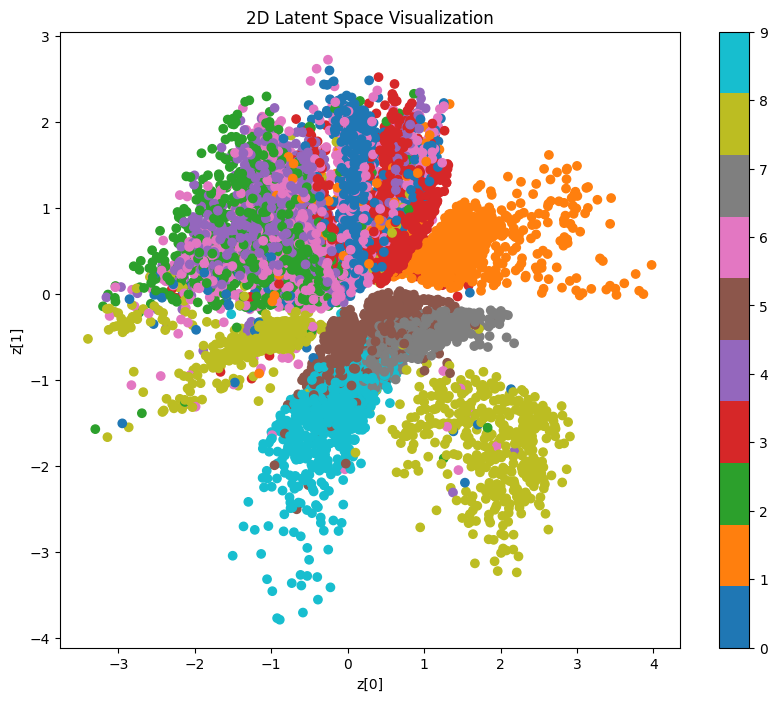

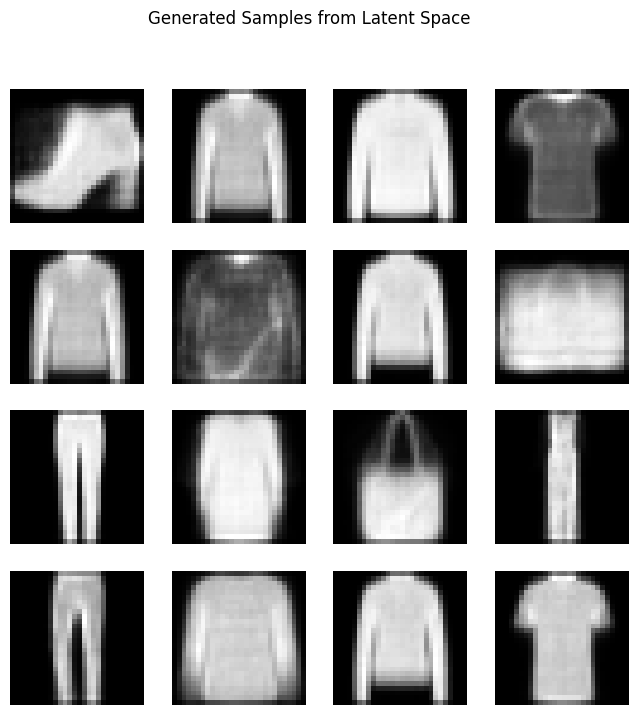

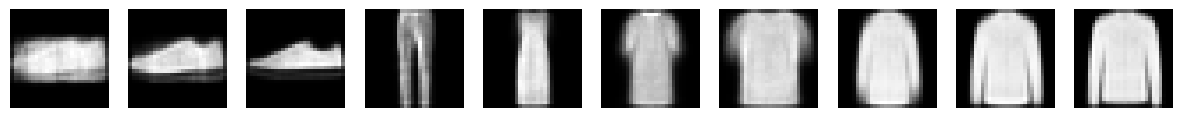

Test Loss: 255.4152


In [ ]:
# 1. Setup Environment

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load and Prepare Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# Class labels mapping
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 3. Define VAE Model

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_var = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(-1, 784)
        h = self.encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_var(h)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

# Initialize model
latent_dim = 2
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 4. Train the VAE

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Train Epoch: {epoch} \tLoss: {train_loss/len(train_loader.dataset):.4f}')

epochs = 30
for epoch in range(1, epochs+1):
    train(epoch)

# Save model
torch.save(model.state_dict(), 'fashion_vae.pth')
# 5. Latent Space Visualization

def plot_latent_space(model, dataloader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            recon, mu, logvar = model(images)
            latents.append(mu.cpu().numpy())
            labels.append(label.numpy())

    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    plt.figure(figsize=(10,8))
    scatter = plt.scatter(latents[:,0], latents[:,1], c=labels, cmap='tab10')
    plt.colorbar(scatter, ticks=range(10))
    plt.title('2D Latent Space Visualization')
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.show()

plot_latent_space(model, test_loader)
# 6. Generate New Samples

def generate_samples(model, num_samples=16):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decoder(z).cpu().view(-1, 28, 28)

    fig, axes = plt.subplots(4, 4, figsize=(8,8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.suptitle('Generated Samples from Latent Space')
    plt.show()

generate_samples(model)

# 7. Latent Space Interpolation

def interpolate(model, z1, z2, n_steps=10):
    with torch.no_grad():
        interpolations = []
        alphas = torch.linspace(0, 1, n_steps)
        for alpha in alphas:
            z = alpha*z2 + (1-alpha)*z1
            sample = model.decoder(z).cpu().view(28,28)
            interpolations.append(sample)

    plt.figure(figsize=(15,2))
    for i, img in enumerate(interpolations):
        plt.subplot(1, n_steps, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

# Get random points in latent space
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)
interpolate(model, z1, z2)

# 8. Quantitative Evaluation

def evaluate(model, dataloader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()

    print(f'Test Loss: {test_loss/len(dataloader.dataset):.4f}')

evaluate(model, test_loader)
